# 💎 Diamond Price Prediction - ML Group Project

## 👥 A Team Full of Diamonds 
- **Anindya**
- **Jairo**
- **Peter**
- **Stefano**
- **Tiago**

## 📌 Project Overview
This project aims to develop a **machine learning model** to accurately predict the price of diamonds based on key attributes such as **carat, cut, color, clarity, and more**. 

By leveraging **data science techniques**, our goal is to create a **robust and reliable model** that provides pricing insights for:
- **Buyers** looking for fair market prices.
- **Sellers** seeking competitive pricing.
- **Enthusiasts** interested in diamond valuation.

## 📊 Dataset
We are using a **publicly available dataset** that includes various features influencing diamond prices:

| Feature  | Description |
|----------|------------|
| **Carat** | Weight of the diamond. |
| **Cut** | Quality of the diamond's cut (**Fair, Good, Very Good, Premium, Ideal**). |
| **Color** | Diamond color grade (**J (worst) to D (best)**). |
| **Clarity** | Measurement of internal flaws (**I1 (worst) to IF (best)**). |
| **Depth** | Total depth percentage. |
| **Table** | Width of the top of the diamond relative to its widest point. |
| **X, Y, Z** | Dimensions of the diamond in mm. |
| **Price** | The price of the diamond in USD (**target variable**). |

## 🛠️ Technologies Used
- **Python** (Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn)
- **Jupyter Notebook**
- **Machine Learning Algorithms** (Regression models)
- **Data Preprocessing & Feature Engineering**

## 🚀 Goals & Expected Outcomes
- Develop an **accurate predictive model** for diamond prices.
- Understand the **impact of different attributes** on pricing.
- Provide **data-driven insights** for valuation.


In [4]:
!python --version

Python 3.12.9


In [8]:
# Import libraries
import openml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

In [2]:
# Load the diamond dataset from OpenML
dataset = openml.datasets.get_dataset(42225)  # Diamond dataset ID on OpenML
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [3]:
# Explore the dataset
df = pd.concat([X, y], axis=1)
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (53940, 10)
   carat      cut color clarity  depth  table     x     y     z  price
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43    326
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31    326
2   0.23     Good     E     VS1   56.9   65.0  4.05  4.07  2.31    327
3   0.29  Premium     I     VS2   62.4   58.0  4.20  4.23  2.63    334
4   0.31     Good     J     SI2   63.3   58.0  4.34  4.35  2.75    335


/opt/blue-python/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


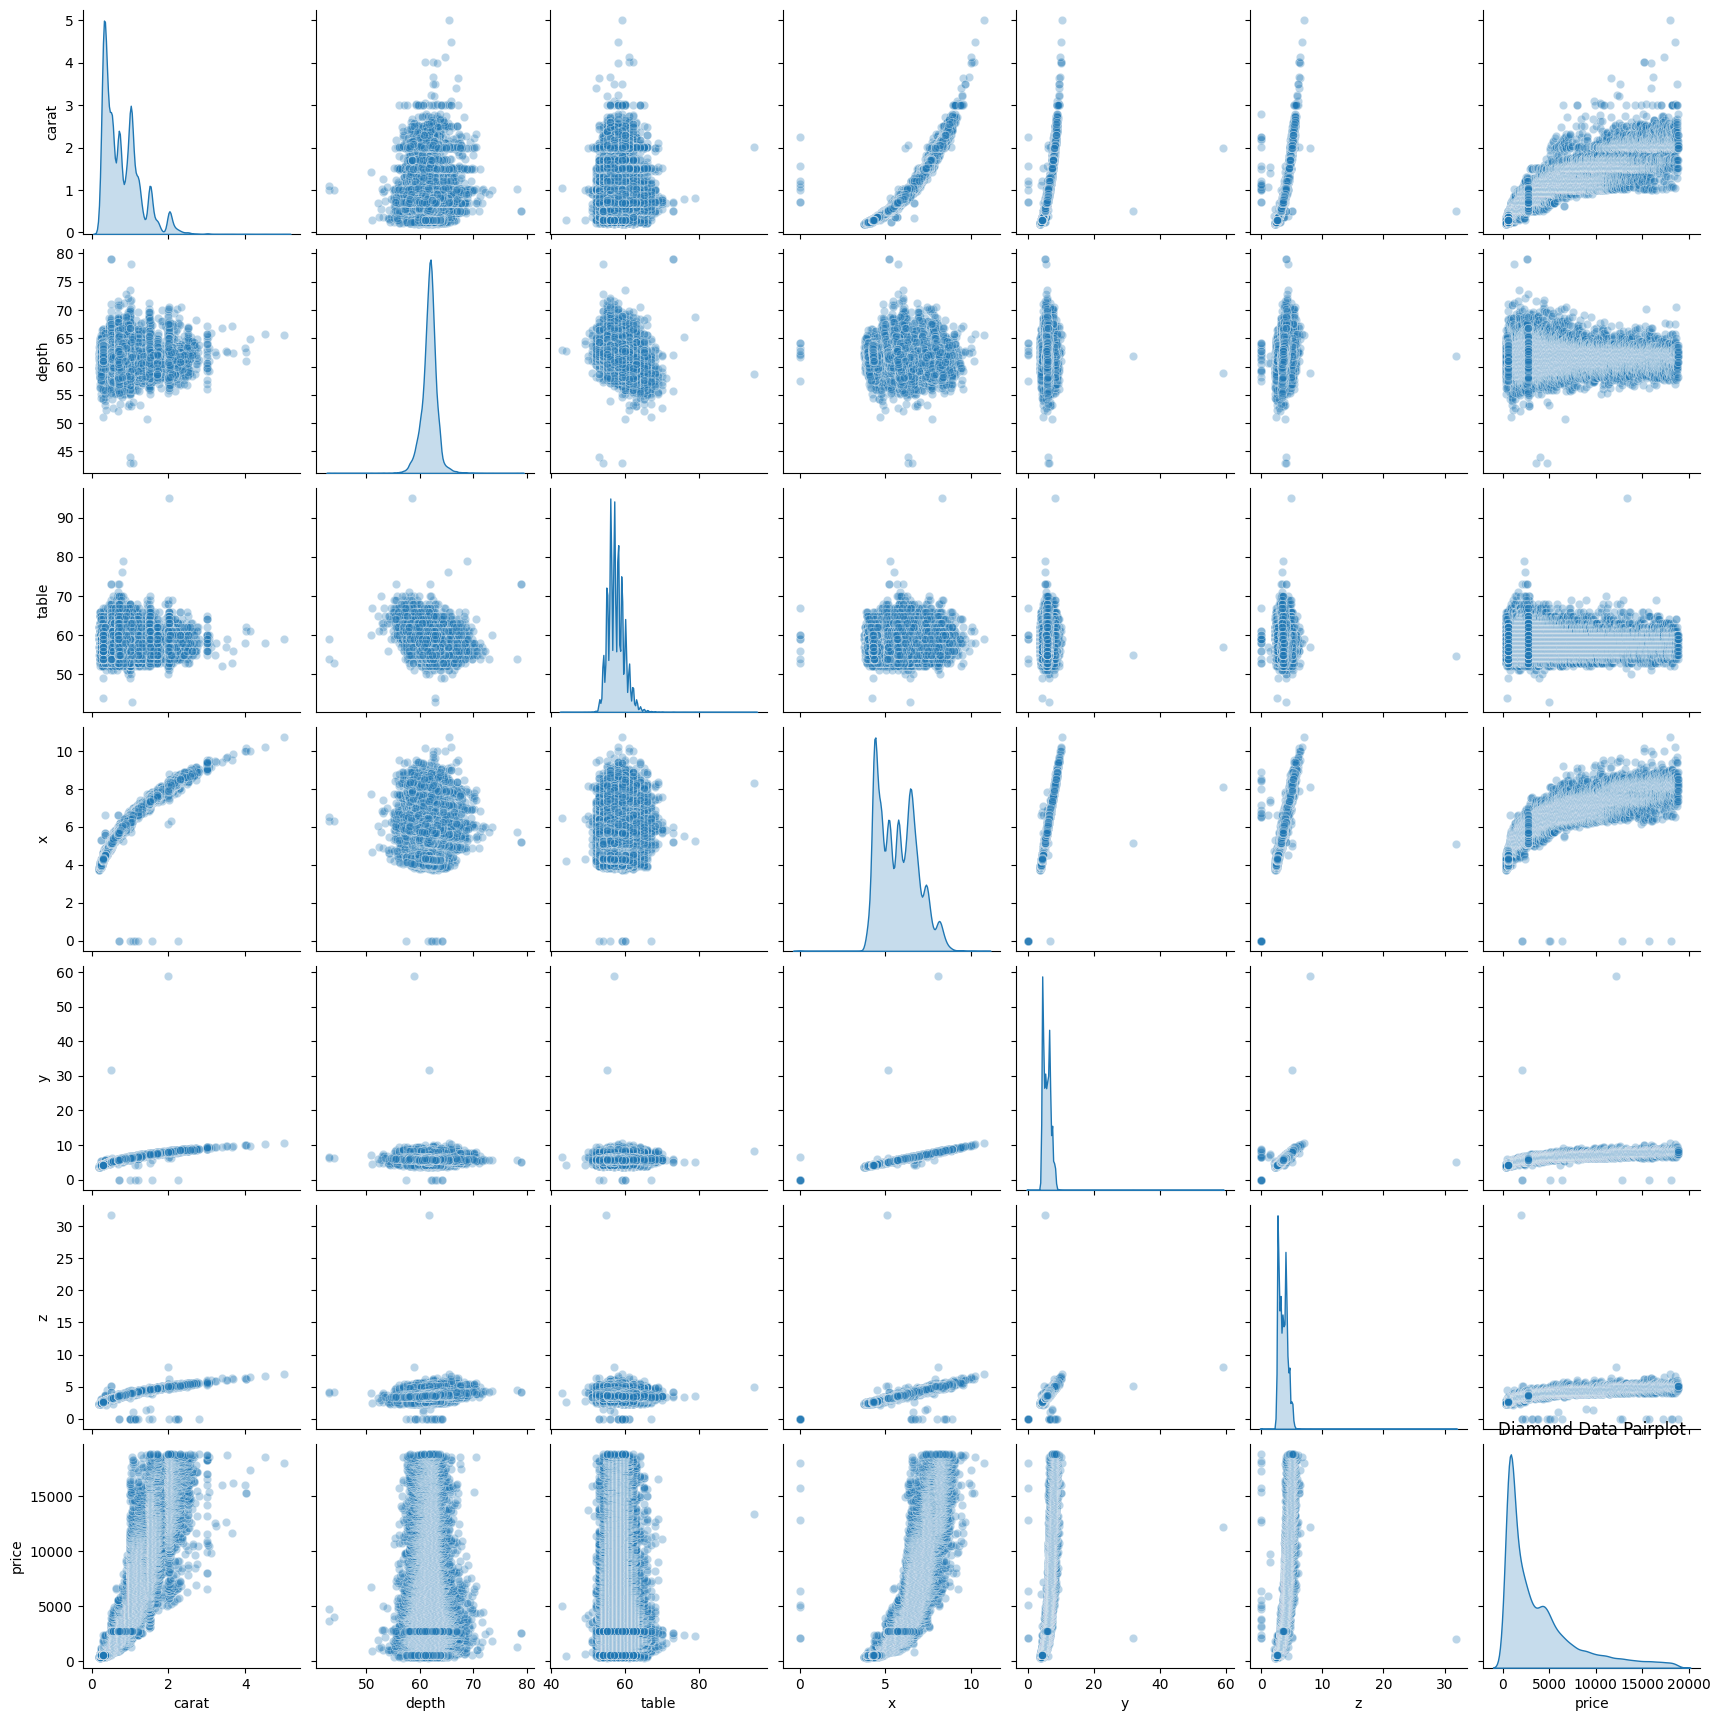

In [4]:
# Basic visualization
sns.pairplot(df, diag_kind='kde',plot_kws={'alpha': 0.3})
plt.title('Diamond Data Pairplot')
plt.show()

### Insights From this Visualization
1. Carat vs. Price:
   - strong positive correlation between carat weight and price
   - a few high-carat diamonds have extremely high prices, which skews the distribution.
2. Depth and Table vs. Price:
   - depth and table do not show strong relationship with price-> they are not the best predictors
3. x,y,z vs Price:
   - x,y,z are highly correlated with each other
   - they also higly correlate with carat, but with some outliers

To Improve the visualization and get more insights we did the following modifications on the data:
1. Applied log transformation on "price" -> the price distribution was heavily right skewed with a long tail (there were a few veryhigh priced diamond), therefore the mean was much higher the median, this can be missleading, with log transformation we made it to normal ()the extreme values have less influance with this)
2. Using Volume which = X*Y*Z _> this volume represents the overall dimaon size

In [5]:
# Statistical summary of numerical features before Feature engineering
print(df.describe())

# Check for null values in the dataset
print("Null Values in Dataset:\n", df.isnull().sum())

# Distribution of target variable
print("Target Variable Distribution:\n", y.value_counts())

              carat         depth         table             x             y  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184      5.731157      5.734526   
std        0.474011      1.432621      2.234491      1.121761      1.142135   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.700000      5.710000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z         price  
count  53940.000000  53940.000000  
mean       3.538734   3932.799722  
std        0.705699   3989.439738  
min        0.000000    326.000000  
25%        2.910000    950.000000  
50%        3.530000   2401.000000  
75%        4.040000   5324.250000  


### Isnights From the descriptive statistics:
1. Carat & Price are right-skewed → Consider log transformation.
2. Some diamonds have x = 0, y = 0, z = 0 → Potential data errors, should be removed.
3. Volume (x × y × z) could be a better feature than separate x, y, z.
4. Extreme depth & table values exist → Filter or investigate further.

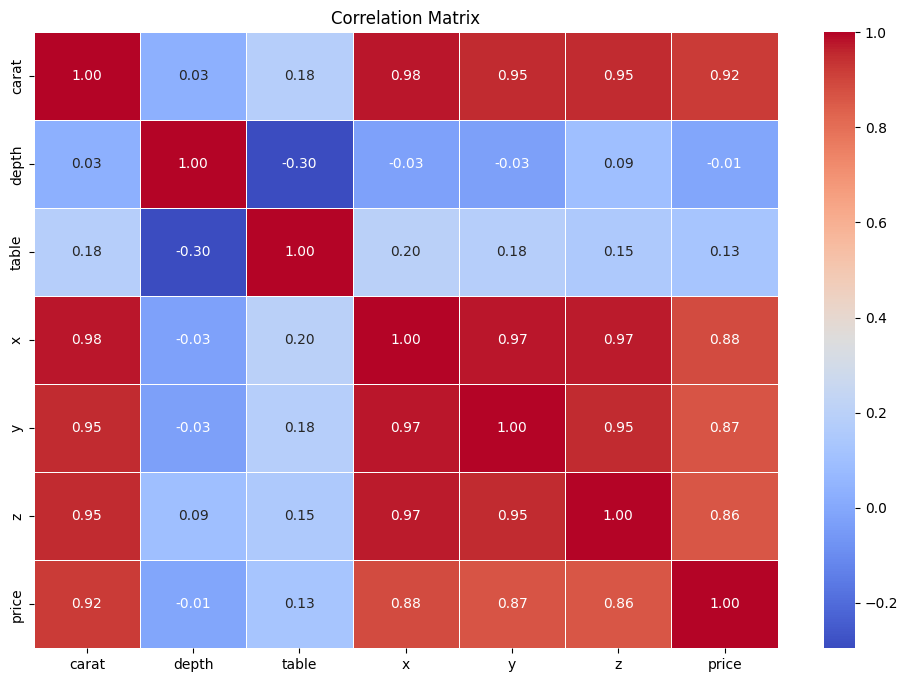

In [6]:
# Correlation matrix excluding categorical columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Insights from the Correlation Heatmap:
- Carat weight is highly correlated with diamond dimensions (x, y, z), meaning larger diamonds tend to have bigger dimensions
- Carat is the strongest predictor of price—as expected, larger diamonds are more expensive.
- Since x, y, z are highly correlated with carat, their relationship with price is also strong.
- Depth and table do not significantly impact price, suggesting they are less useful predictors-> these features affect a diamond’s appearance but not necessarily its price directly

In [4]:
# Assuming df is the original dataset
df_pre = df.copy()  # Copy original data

# Step 1: Create the 'volume' feature
df_pre["volume"] = df_pre["x"] * df_pre["y"] * df_pre["z"]

# Step 2: Apply log transformation to 'price'
df_pre["log_price"] = np.log(df_pre["price"])

# Step 3: Keep only the required columns
df_pre = df_pre[["carat","cut",'color', 'clarity', "depth", "table", "volume", "log_price"]]

/opt/blue-python/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


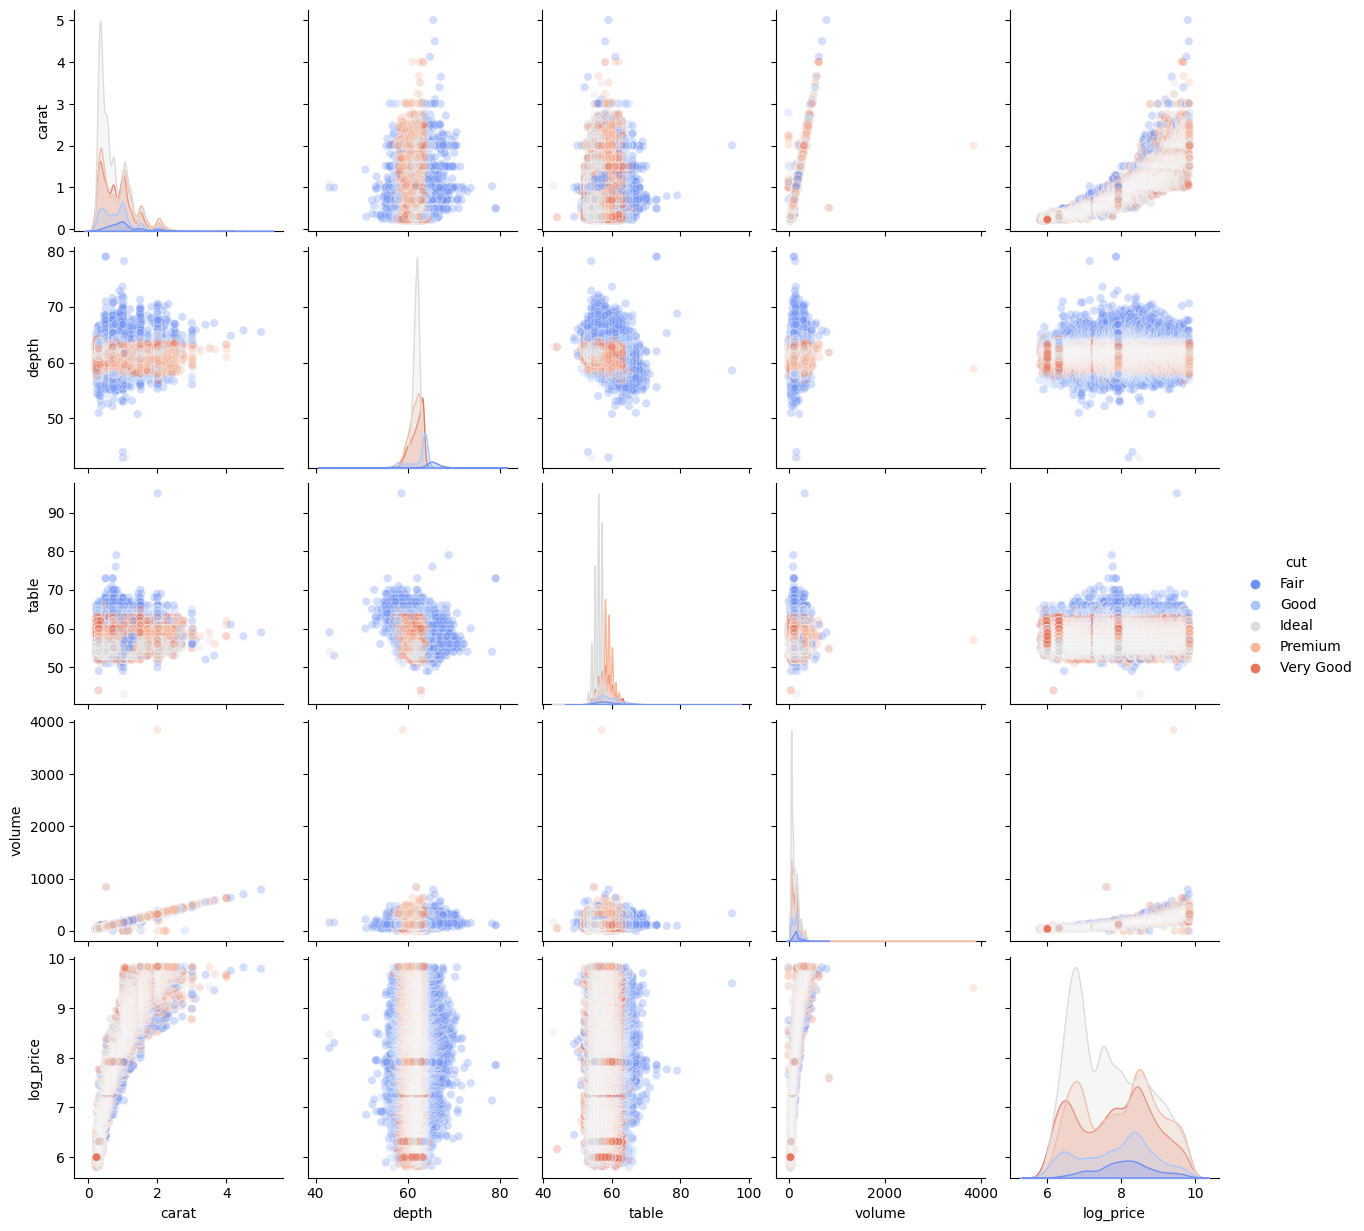

In [10]:
# Create improved pair plot
sns.pairplot(df_pre, 
             vars=["carat", "depth", "table", "volume", "log_price"], 
             hue="cut",  # Add categorical variable
             palette="coolwarm", 
             plot_kws={'alpha': 0.3})

### Visual 2.
This pair plot (scatterplot matrix) provides insights into the relationships between different diamond attributes, including carat, depth, table, volume, and log-transformed price (log_price). The colors represent different diamond cuts (Fair, Good, Ideal, Premium, Very Good).

#### Insights
- strong positive correlation between carat and price (log price)
- higher cara diamonds tend to have higher prices, but there are variations based on cut quality
- fair cut diamonds tend to be cheaper than premium and ideal cuts
- Volume shows a weak, non-linear correlation with price
- some diamonds have unexpectdly low prices for hight volumes-> these can be misclassified diamonds
- depth and table do not show strong correlations with price-> most values are concentrated around the standard diamond proportion
- distribution of depth is fairly normal, while table has some outliers
- depth and table alone are not strong predictors of the price, but they still might have a little influence
- the log prices shows better after then the raw price -> Ideal and Premium cuts have higher prices on avg, while fair and Godd cuts have wider price spread

### Data Issues
- outliers in volume, depth and table can be due to data entry errors or unusual diamonds
- some high volume diamonds have unexpectedly low prices (-> we might handle this)

### Get Descriptive Stats about the modified data

In [11]:
# Statistical summary of numerical features before Feature engineering
print(df_pre.describe())

# Check for null values in the dataset
print("Null Values in Dataset:\n", df_pre.isnull().sum())

# Distribution of target variable
print("Target Variable Distribution:\n", y.value_counts())


              carat         depth         table        volume     log_price
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000
mean       0.797940     61.749405     57.457184    129.849403      7.786768
std        0.474011      1.432621      2.234491     78.245262      1.014649
min        0.200000     43.000000     43.000000      0.000000      5.786897
25%        0.400000     61.000000     56.000000     65.136830      6.856462
50%        0.700000     61.800000     57.000000    114.808572      7.783641
75%        1.040000     62.500000     59.000000    170.842451      8.580027
max        5.010000     79.000000     95.000000   3840.598060      9.842835
Null Values in Dataset:
 carat        0
cut          0
depth        0
table        0
volume       0
log_price    0
dtype: int64
Target Variable Distribution:
 605      132
802      127
625      126
828      125
776      124
        ... 
13061      1
13074      1
13075      1
13077      1
13078      1
Name: price, L

### Isnights From the descriptive statistics:

#### Carat (Diamond Weight)
Mean: 0.798, Median: 0.7, Max: 5.01
Most diamonds are less than 1 carat (as seen from the 25th percentile (0.4) and 75th percentile (1.04)).
Right-skewed distribution → A few large diamonds pull the mean (0.798) above the median (0.7).
Implication: Since carat strongly influences price, we expect larger carat values to correlate with higher prices.

#### Depth (%)
Mean: 61.75%, Median: 61.8%, Range: 43% - 79%
Most diamonds have a depth between 61.0% (Q1) and 62.5% (Q3), which is within the optimal range (57-63%) for well-cut diamonds.
Min depth = 43% and max = 79% → Possible outliers (either poorly cut diamonds or data errors).
Implication: Since depth has weak correlation with price, extreme depth values may indicate diamonds with poor light performance.

#### Table (%)
Mean: 57.46%, Median: 57%, Range: 43% - 95%
Most diamonds have a table between 56% (Q1) and 59% (Q3), which is close to the ideal range (53-60%).
Table values above 65% or below 50% might be poorly cut diamonds.
Implication: Since table has a weak correlation with price, extreme values could indicate unusual or less desirable diamonds.

#### Log_Price
Mean: 7.79, Median: 7.78, Max: 9.84, Min: 5.79
Why log transformation? The original price was right-skewed, so applying log(price) makes the distribution more normal.
The log price range of 5.79 to 9.84 corresponds to a price range of $ 326 to $18,823 in the original data.
Implication: A nearly normal log_price distribution makes linear regression models work better.

#### Volume
Mean: 129.85, Median: 114.81, Max: 3,840.60, Min: 0.00
Min volume = 0.00 → Possible data errors (some diamonds have zero dimensions).
Right-skewed distribution → A few diamonds with extremely large volume.
Implication: Since volume is highly correlated with carat, it is a good alternative feature to replace x, y, z.

### Boxplot Visualization for Outliers Check

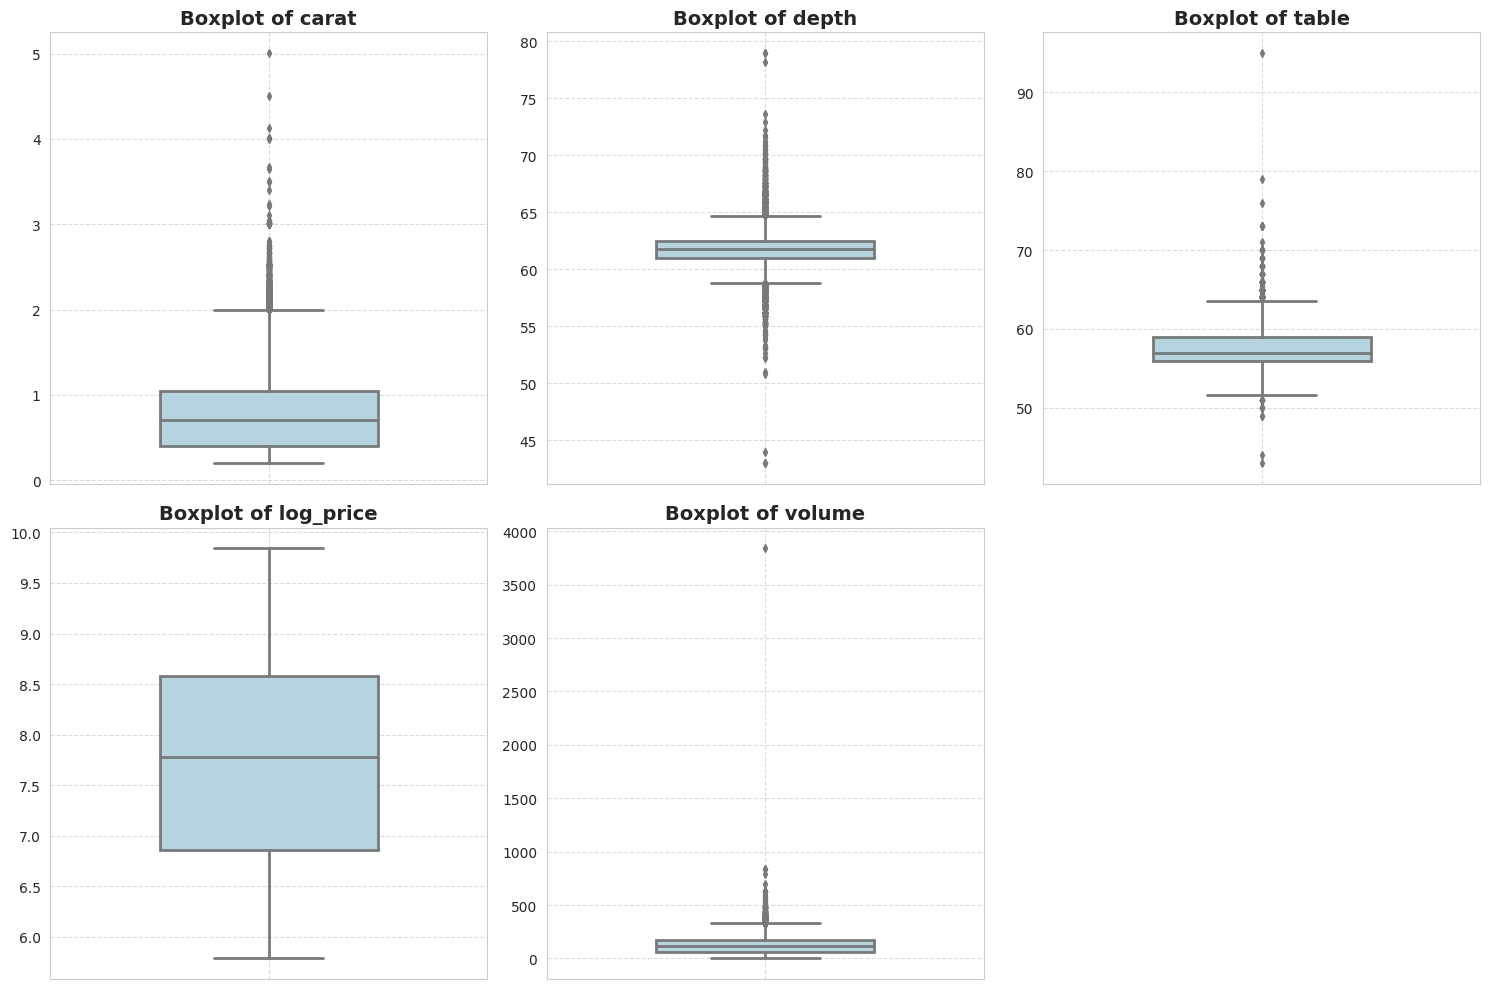

In [155]:
# Set Seaborn style for better visuals
sns.set_style("whitegrid")

# Define features to plot
features = ["carat", "depth", "table", "log_price", "volume"]

# Set figure size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array for easier iteration

# Create boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(y=df_pre[feature], ax=axes[i], color="lightblue", width=0.5, linewidth=2, fliersize=4)
    axes[i].set_title(f"Boxplot of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("")  # Remove y-axis labels for cleaner look
    axes[i].grid(True, linestyle="--", alpha=0.7)  # Light grid for readability

# Remove empty subplot (since we have only 5 features)
fig.delaxes(axes[-1])

# Improve layout
plt.tight_layout()
plt.show()

### Isnights From BoxPlots: 

#### Carat
- most diamonds are small, with the middle 50% (IQR) between ~0.4 and 1.04 carats.
- lots of outliers above 2 carats (luxury diamonds).
- Implication: The carat distribution is right-skewed, and we may need a log transformation to reduce the impact of extreme values.

#### Depth
- most diamonds have depth around 60-62% (the ideal range).
- Outliers exist below 50% and above 70% (potentially poorly cut diamonds).
- Implication: Depth has weak correlation with price, so we might not need it as a key predictor.

#### Table 
- most diamonds have a table between 56-60%, which is within the recommended range.
- outliers exist below 50% and above 70% (unusual proportions).
- Implication: If extreme table values correlate with poor diamond quality, we might want to remove them.

#### Log Price
- no extreme outliers—the log transformation helped normalize price distribution.
- Implication: The model will perform better with log_price instead of raw price.

#### Volume
- huge range of values with many extreme outliers.
- some diamonds have volume = 0, which is a clear data error
- Implication:Diamonds cannot have zero volume, so these should be removed and the right-skewed distribution suggests we might need a log transformation.

/tmp/ipykernel_27898/2223293560.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_pre.corr(), annot=True, cmap="coolwarm", fmt=".2f")


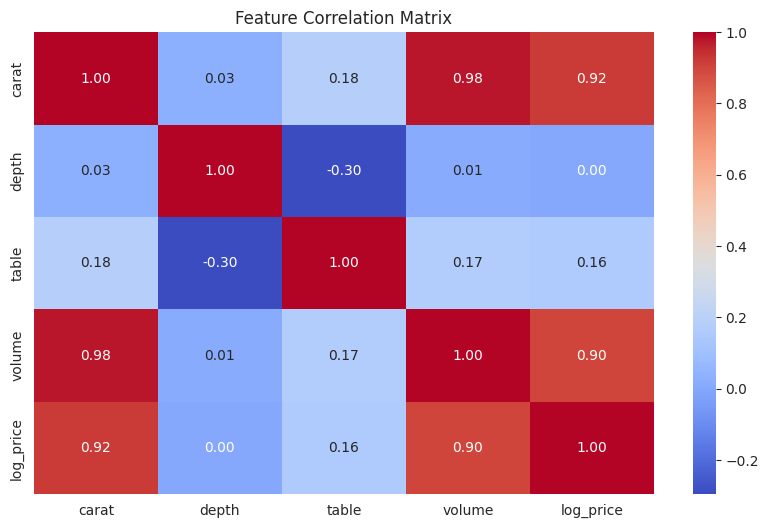

In [148]:
#Create Correlation HeatMap for the preprocessed data

plt.figure(figsize=(10, 6))
sns.heatmap(df_pre.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Insights
#### Carat and Volume
- Extremely high correlation, meaning they provide almost the same information.
- Drop one (probably volume) to reduce redundancy.
#### Carat and Log Price
- Strong positive correlation—Carat is a strong predictor of price.
#### Table and Log Price
- may have a minor impact on price
- Keep for now but monitor its importance.
#### Depth and Log Price
- depth may not be a useful feature for predicting price
- Consider dropping Depth if models improve without it.

In [5]:
### Drop the columns

df_pre=df_pre[(df_pre["table"] > 50) & (df_pre["table"] < 70)]

df_pre = df_pre[(df_pre["depth"] > 50) & (df_pre["depth"] < 70)]

df_pre_v2=df_pre[["carat","cut",'color','clarity',"table","log_price"]]

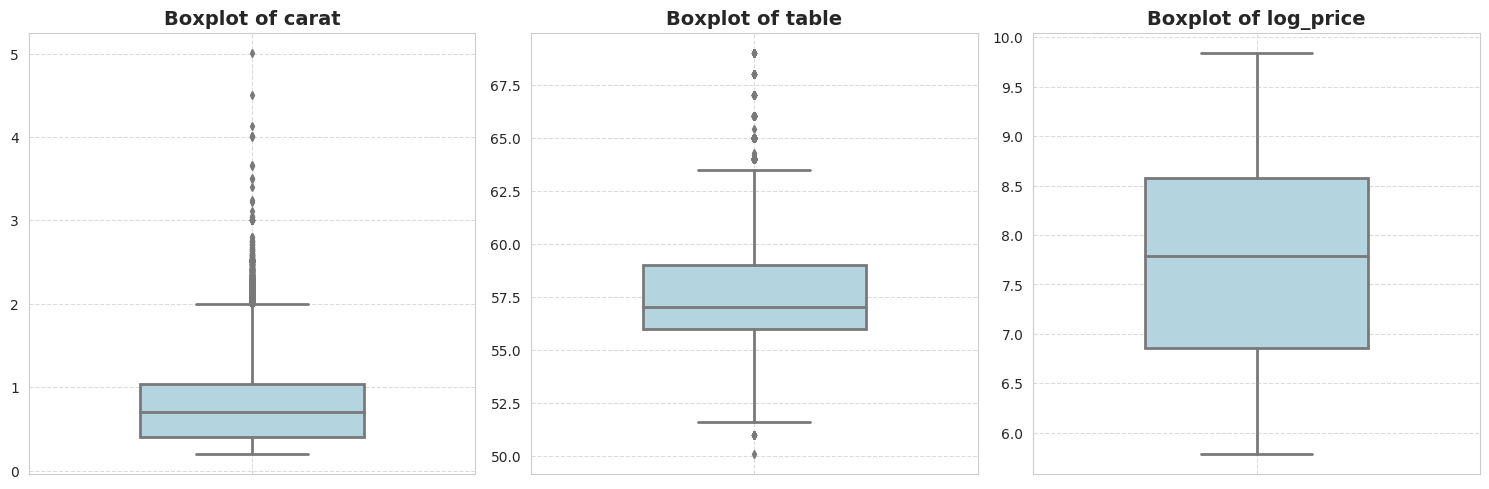

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("whitegrid")

# Define features
features = ["carat", "table", "log_price"]

# Check if all features exist
missing_features = [f for f in features if f not in df_pre_v2.columns]
if missing_features:
    print(f"⚠️ Warning: The following features are missing from df_pre_v2: {missing_features}")

# Filter only existing features
features = [f for f in features if f in df_pre_v2.columns]

# Adjust grid size dynamically
num_features = len(features)
num_cols = min(3, num_features)
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = np.array(axes).flatten()  # Flatten for easier iteration

# Plot boxplots
for i, feature in enumerate(features):
    sns.boxplot(y=df_pre_v2[feature], ax=axes[i], color="lightblue", width=0.5, linewidth=2, fliersize=4)
    axes[i].set_title(f"Boxplot of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle="--", alpha=0.7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Improve layout
plt.tight_layout()
plt.show()


### Isnights From BoxPlots after removeing outliers
#### Carat
- Median (middle line in the box) is around 0.75 to 1.0.
- Outliers (dots above the whiskers) → High-carat diamonds above ~2.5.
- Right-skewed distribution → More smaller diamonds, fewer larger ones.#### Table
#### Log Price
- The log transformation worked well.
#### Table
- Outliers above 65 → These may represent diamonds with unusually large table sizes.
- More spread-out distribution compared to carat
- Capping extreme values (e.g., removing values above 70) might improve model performance.

In [6]:
## Create a Data Preprocessing Function
# Data Preprocessing Function
def preprocess_data(df, use_polynomial=False):
    # Define features and target variable
    X = df.drop(columns=["log_price"])  # Features
    y = df["log_price"]  # Target variable

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Identify categorical and numerical columns
    categorical_features = ["cut", "color", "clarity"]
    numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.difference(categorical_features)

    ### Encode Categorical Variables ###
    encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)

    # Fit encoder on training set
    X_train_encoded = encoder.fit_transform(X_train[categorical_features])
    X_test_encoded = encoder.transform(X_test[categorical_features])

    # Convert to DataFrame and retain column names
    train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_features))
    test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_features))

    # Drop original categorical features and concatenate encoded features
    X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)
    X_test = X_test.drop(columns=categorical_features).reset_index(drop=True)

    X_train = pd.concat([X_train, train_encoded_df], axis=1)
    X_test = pd.concat([X_test, test_encoded_df], axis=1)

    # Scale Numerical Features
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

    if use_polynomial:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)

    # Return fitted encoder, polynomial transformer (if used), and `use_polynomial` flag
    return X_train, X_test, y_train, y_test, encoder, poly if use_polynomial else None, use_polynomial


In [7]:
#Finalize the dataset and drop Volume and Depth
df_final=df_pre[["carat","cut",'color', 'clarity', "table", "log_price"]]

# MODEL TRAINING

## Linear Regression with Polynomial Features

In [15]:
#Linear Regression
X_train, X_test, y_train, y_test, fitted_encoder,poly, use_polynomial = preprocess_data(df_final, use_polynomial=True)

param_grid = {}

grid_lr=GridSearchCV(LinearRegression(), param_grid,cv=10)
grid_lr.fit(X_train,y_train)

best_lr = grid_lr.best_estimator_
y_train_pred = best_lr.predict(X_train)
y_test_pred = best_lr.predict(X_test)

metrics = {
        "Model": 'LinearRegression',
        "Best Params": grid_lr.best_params_,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Train R2 Score": r2_score(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test R2 Score": r2_score(y_test, y_test_pred),
    }

print(metrics)

{'Model': 'LinearRegression', 'Best Params': {}, 'Train MAE': 0.11449576249303202, 'Train RMSE': 0.14977429613628154, 'Train R2 Score': 0.9783167262938062, 'Test MAE': 0.1153770898870799, 'Test RMSE': 0.15843692761018796, 'Test R2 Score': 0.9752814744594966}


## Insights
- Linear Regression model has been trained and evaluated. The results indicate excellent predictive performance with minimal overfitting. Let's analyze the key metrics:
- MAE: Low error, good prediction accuracy
- RMSE: Small deviation, robust model
- R² Score: Very high, excellent fit

/opt/spark/work-dir/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


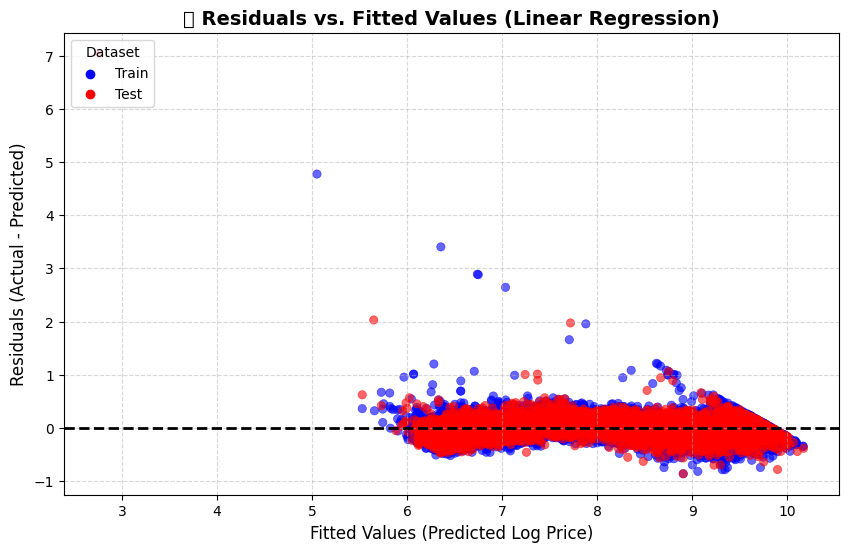

In [35]:
## Create Residual Plot

import matplotlib.pyplot as plt

# Compute Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create DataFrame for easy plotting
residuals_df = pd.DataFrame({
    "Fitted Values": np.concatenate([y_train_pred, y_test_pred]),
    "Residuals": np.concatenate([train_residuals, test_residuals]),
    "Dataset": ["Train"] * len(y_train_pred) + ["Test"] * len(y_test_pred)
})


plt.figure(figsize=(10, 6))
sns.scatterplot(data=residuals_df, x="Fitted Values", y="Residuals", hue="Dataset", alpha=0.6, edgecolor=None, palette={"Train": "blue", "Test": "red"})
plt.axhline(y=0, color="black", linestyle="--", linewidth=2)  # Reference line at 0
plt.title("📊 Residuals vs. Fitted Values (Linear Regression)", fontsize=14, fontweight="bold")
plt.xlabel("Fitted Values (Predicted Log Price)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.legend(title="Dataset", loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

### Insights from the plot

1. Residuals are mostly centered around 0
 - The horizontal dashed black line at 0 represents an ideal model with no systematic bias.
2. Rightward funnel shape -> potential heteroscedasticity
3. A few large residuals -> blue points above 3

This plot does suggest mild heteroskedasticity, as residual variance seems to change across different fitted values.

Feature Names Length: 209
Coefficients Length: 209


/opt/spark/work-dir/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


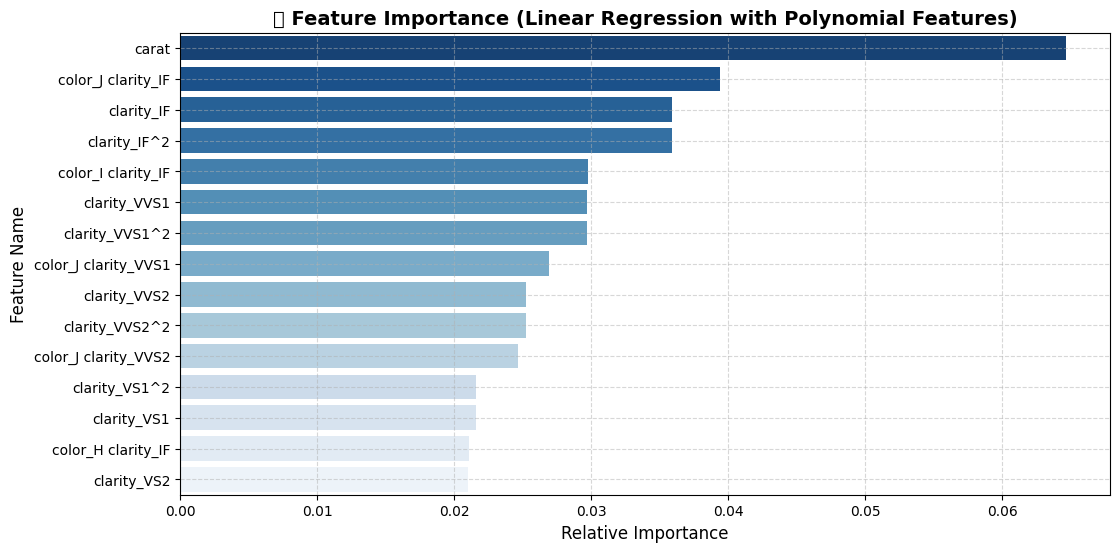

In [44]:
## Check Feature Importance

# Run preprocessing & get encoder and polynomial transformer
X_train, X_test, y_train, y_test, fitted_encoder, poly_transformer, use_polynomial = preprocess_data(df_final, use_polynomial=True)

# Extract categorical feature names from fitted OneHotEncoder
categorical_feature_names = fitted_encoder.get_feature_names_out(["cut", "color", "clarity"]).tolist()

# Extract numerical feature names (before encoding)
numerical_feature_names = df_final.select_dtypes(include=["float64", "int64"]).columns.difference(["cut", "color", "clarity", "log_price"]).tolist()

# Combine numerical + categorical feature names
base_feature_names = numerical_feature_names + categorical_feature_names

# If polynomial features were generated, extract the correct feature names
if use_polynomial and poly_transformer:
    poly_feature_names = poly_transformer.get_feature_names_out(base_feature_names)
    feature_names = poly_feature_names.tolist()  # Use polynomial feature names
else:
    feature_names = base_feature_names  # Use normal feature names if no polynomial features

# Extract coefficients from the best Linear Regression model
coefficients = grid_lr.best_estimator_.coef_

# ✅ Check Lengths Before Creating DataFrame
print(f"Feature Names Length: {len(feature_names)}")
print(f"Coefficients Length: {len(coefficients)}")

if len(feature_names) == len(coefficients):
    # Create DataFrame for feature importance
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": np.abs(coefficients)})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Normalize for better visualization
    feature_importance_df["Importance"] /= feature_importance_df["Importance"].sum()

    # 📊 Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance_df[:15], x="Importance", y="Feature", palette="Blues_r")
    plt.title("📊 Feature Importance (Linear Regression with Polynomial Features)", fontsize=14, fontweight="bold")
    plt.xlabel("Relative Importance", fontsize=12)
    plt.ylabel("Feature Name", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("❌ Error: Feature names and coefficients have different lengths. Check encoding process.")



/opt/spark/work-dir/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


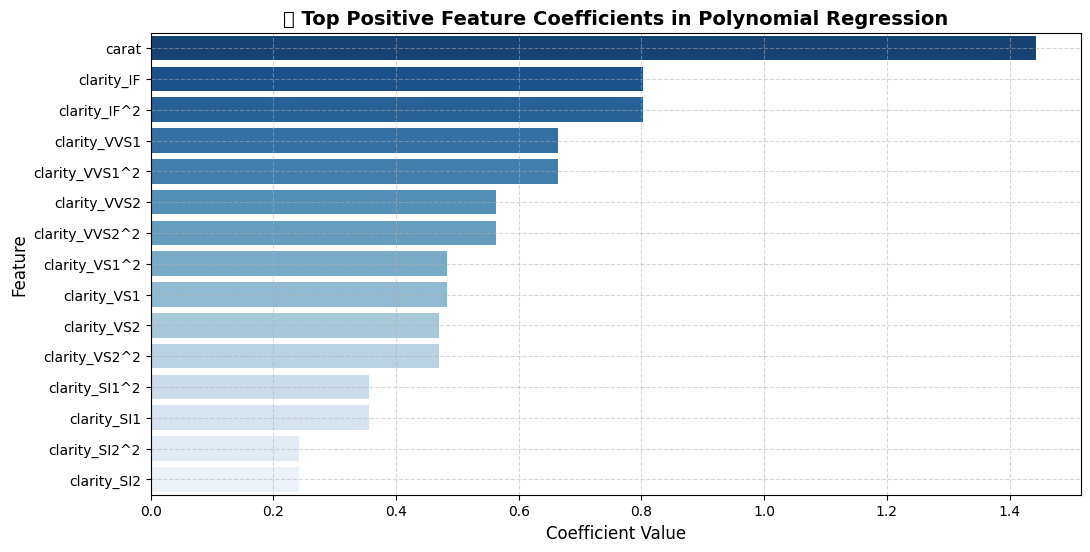

In [18]:
feature_names = poly.get_feature_names_out()

# Extract model coefficients
coefficients = best_lr.coef_

# Combine into a DataFrame for better readability
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Sort by absolute coefficient values (most important features first)
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)
coef_df = coef_df[coef_df["Coefficient"] > 0]

coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Step 7: Plot the Top 15 Positive Coefficients
plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df[:15], x="Coefficient", y="Feature", palette="Blues_r")
plt.title("📊 Top Positive Feature Coefficients in Polynomial Regression", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/opt/spark/work-dir/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


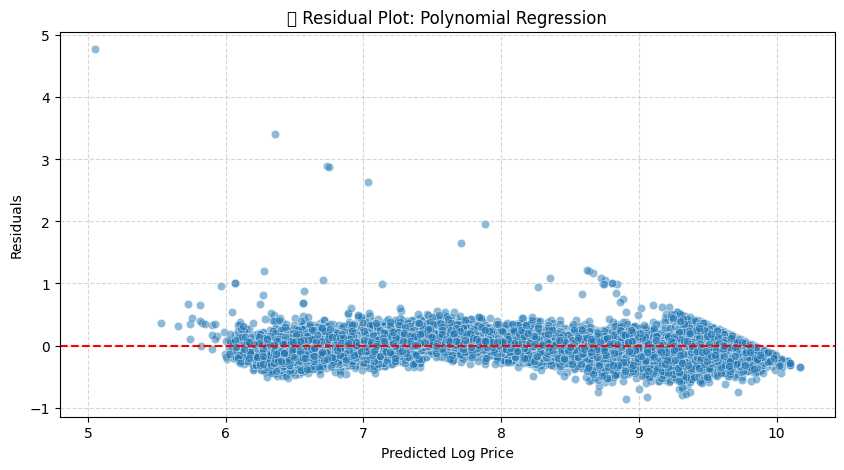

In [22]:
y_train_pred = best_lr.predict(X_train)

# Residuals
residuals = y_train - y_train_pred

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_train_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("📊 Residual Plot: Polynomial Regression")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


### Insights
1. The weight of the diamond (carat) dominates the prediction, confirming that diamond size is the strongest determinant of price.
2. Features like clarity_IF^2 and clarity_VVS1^2 appear in the top 15, indicating that clarity has a nonlinear impact on price.-> Polynomial Features Matter
3. The interaction terms are created by the polynomial feature transformation and these interaction terms are significant. The presence of interaction terms (color_J * clarity_IF, color_H * clarity_IF) indicates that the combination of color and clarity plays a role in determining price. 

### NEXT STEPS

Our Linear Regression model is already excellent, with a Test R² of 0.975. This means 97.5% of the variance in price is explained by the model—a near-perfect fit. In this case, a tree-based model (like Random Forest or XGBoost) may not be necessary unless you have specific reasons to test it.Also we have a mild heteroskedasticity which suggests that we do not have constant variance, violating the assumption of linear regression.Therefore we try to train a small XGBoost model with fewer trees and lower complexity checking if it improves Test R².

## XGBoost

In [12]:
#XGBoost
X_train, X_test, y_train, y_test, fitted_encoder,poly,use_polynomial = preprocess_data(df_final, use_polynomial=False)

param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.01, 0.05],
    "max_depth": [3, 6],
    "min_child_weight": [1, 5],
    "colsample_bytree": [0.5, 0.7],
    "subsample": [0.5, 0.7],
    "gamma": [0.1, 0.3]
}

grid_xgb=GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid,cv=10)
grid_xgb.fit(X_train,y_train)

best_model = grid_xgb.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
        "Model": 'XGBoost',
        "Best Params": grid_xgb.best_params_,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Train R2 Score": r2_score(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test R2 Score": r2_score(y_test, y_test_pred),
    }

print(metrics)

{'Model': 'XGBoost', 'Best Params': {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}, 'Train MAE': 0.07929808308031942, 'Train RMSE': 0.10547561816361409, 'Train R2 Score': 0.9892463861850324, 'Test MAE': 0.0823302591815621, 'Test RMSE': 0.10917750947092991, 'Test R2 Score': 0.9882624865314743}


### Insights

- Train R²: 0.8918 → Test R²: 0.8913 → XGBoost generalizes well (no overfitting), but it still lags behind Polynomial Regression (0.9752 Test R²).
- MAE and RMSE are higher in XGBoost, meaning larger prediction errors.
-Polynomial Regression still outperforms XGBoost in all metrics.--> The relationship between diamond features and price is mostly smooth, making polynomial regression a natural fit.

Tree-based models like XGBoost usually excel when the data has complex, irregular patterns, but this dataset has mostly smooth nonlinear trends, which polynomial regression captures efficiently.

/opt/spark/work-dir/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


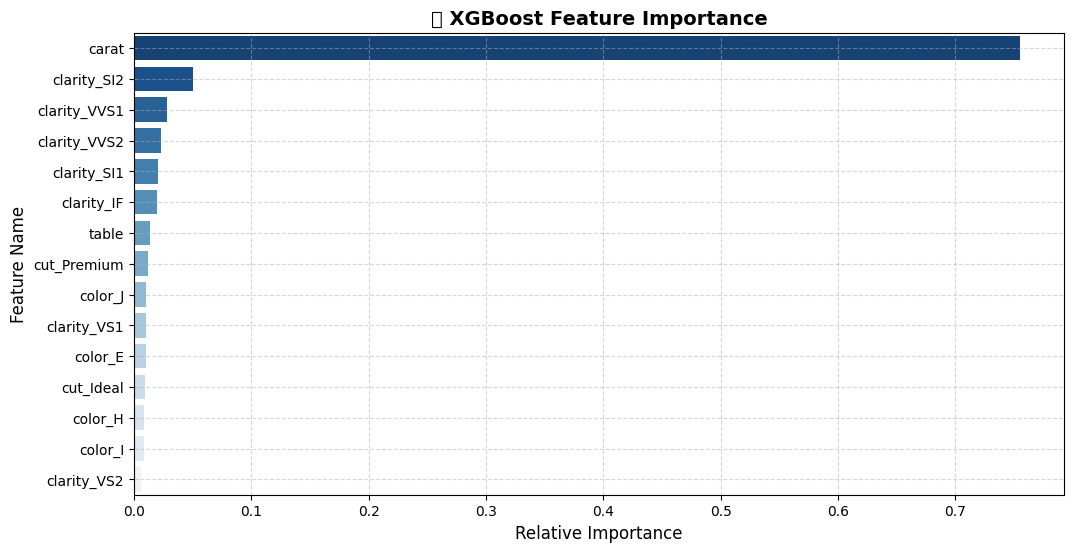

In [9]:
## Feature Importance XGBoost

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract feature importance from XGBoost
importances = best_model.feature_importances_

# Get feature names from training data
feature_names = X_train.columns.tolist()  # Ensure this matches XGBoost input features

# Create DataFrame
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# 📊 Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df[:15], x="Importance", y="Feature", palette="Blues_r")
plt.title("📊 XGBoost Feature Importance", fontsize=14, fontweight="bold")
plt.xlabel("Relative Importance", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Key Insights:
1. Carat Dominates Predictions
- carat is by far the most important feature in the XGBoost model, accounting for the vast majority of the model’s predictive power.
- This aligns with Polynomial Regression, where carat was also the most significant feature.
- This suggests that diamond price is heavily dependent on carat weight, with other factors playing a much smaller role.
2. Clarity Features Are the Next Most Important
- clarity_SI2, clarity_VVS1, clarity_VVS2, clarity_SI1, and clarity_IF are the next most influential factors.
- This makes sense, as clarity impacts diamond pricing, but not as much as carat.
3. Color and Cut Have Less Influence
- cut_Premium, cut_Ideal, and various color categories appear lower in importance.
- This suggests that color and cut do influence price but are secondary factors compared to carat and clarity.
- This is consistent with real-world diamond pricing, where carat weight is the primary driver.


## SUMMARY
### XGBoost vs. Polynomial Regression: Feature Importance Comparison
#### Key Observations:
1. Both Models Agree That Carat Is the Most Important Feature
- In both XGBoost and Polynomial Regression, carat is by far the most dominant factor in predicting diamond prices.
- This confirms that carat weight is the primary driver of diamond prices, as expected.
️2. Polynomial Regression Captures More Interactions
- Polynomial regression highlights interaction terms, such as:
- color_J * clarity_IF
- clarity_IF²
- clarity_VVS1²
- These interaction effects are not explicitly captured by XGBoost, which automatically models nonlinearities without creating explicit polynomial terms.
3. XGBoost Emphasizes Individual Features More
- In XGBoost, clarity_SI2, clarity_VVS1, and clarity_IF are among the next most important features after carat.
- This suggests that XGBoost is treating clarity as a key factor but isn’t explicitly modeling interactions like polynomial regression does.
4. Cut and Color Have Low Influence in Both Models
- Neither model assigns high importance to cut or color.
- This means diamond pricing is more dependent on carat and clarity than on color and cut quality.
#### Which Model Is Better?
- Polynomial Regression has a higher Test R² (0.975 vs. 0.891 for XGBoost), meaning it explains more variance in diamond prices.
- Polynomial Regression explicitly models interactions, which seem to be important in this dataset.
- XGBoost is still a strong model, but it does not fully capture the same interaction effects as Polynomial Regression.